In [1]:
import os
# os.sys.path.append("C:\\Users\\markp\\repos\\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import pickle
import itertools

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df[(df['ImagingRegion']=='CA1' )|(df['ImagingRegion']=='')]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [4]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sess = [5,5,5,3,5,2,4,4,4,4,4,4]
rare = [i<5 for i in range(len(mice))]
freq = [(1-r)>0 for r in rare]
rare_mice = mice[:6]
freq_mice = mice[6:]
print(freq_mice)

['4222153.1', '4222153.2', '4222153.3', '4222174.1', '4222154.1', '4343702.1']


In [ ]:
morphbin = np.linspace(-.11,1.11,num=11)
datadict = {}
for m,mouse in enumerate(mice):
    print(mouse)
    df_mouse = df[df["MouseName"]==mouse]
    datadict[mouse]={}
    for ind in range(first_sess[m],df_mouse.shape[0]):
        print(ind)
        datadict[mouse][ind]={}
        sess = df_mouse.iloc[ind]
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        VRDat,S = data['VRDat'],data['S']
        print(data.keys())
        S[np.isnan(S)]=0
        S = S/np.percentile(S,95,axis=0)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0
        masks, SI,pvals = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        data['tstart_inds'], data['teleport_inds'],
                        win_trial_perm=True,morphlist=[0,.25,.5,.75,1],bootstrap=False,nperms=1000)
        
        morphs = trial_info['morphs']+trial_info['wallJitter']
        
        datadict[mouse][ind] = {'masks':masks,'S_trial_mat':S_trial_mat,'trial_info':trial_info,'pvals':pvals}

In [39]:
print(datadict['4343706'].keys())
# datadict['4343706'].pop(8)
# datadict['4343706'].pop(6)
# datadict['4343706'].pop(2)
print(datadict['4343706'][3]['pvals'][0],datadict['4343706'][3]['masks'][0])

dict_keys([3, 4, 5, 7])
[0.085 0.979 0.    ... 0.275 0.011 0.884] [ True  True  True ... False  True False]


In [23]:
with open("D:\\Morph_Results\\PCResults.pkl","wb") as f:
    pickle.dump(datadict,f)
    

In [5]:
with open("D:\\Morph_Results\\PCResults.pkl","rb") as f:
    datadict = pickle.load(f)
    

(120, 45, 1498)


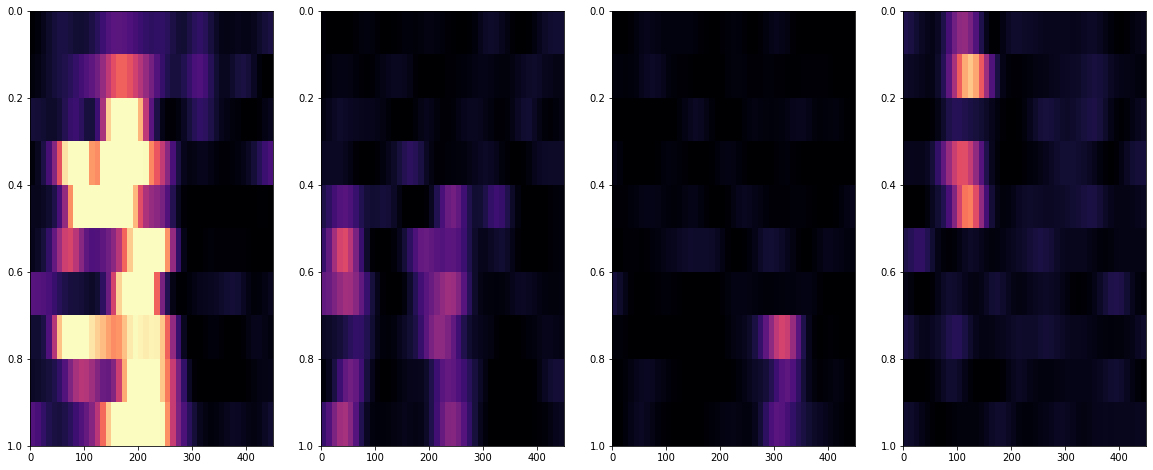

In [6]:
print(datadict['4139265.4'][9]['S_trial_mat'].shape)
morphbin = np.linspace(-.05,1.1,num=11)
morphs = datadict['4139265.4'][9]['trial_info']['morphs'] + datadict['4139265.4'][9]['trial_info']['wallJitter']
morphdig = np.digitize(morphs,morphbin)
S_tm_sig = sp.ndimage.filters.gaussian_filter1d(datadict['4139265.4'][9]['S_trial_mat'],2,axis=1)
S_tm_sig /=S_tm_sig.ravel().mean()
S_tm_bin = np.zeros([10,S_tm_sig.shape[1],S_tm_sig.shape[2]])
for i in range(10):
    if (morphdig==i).sum()>0:
        S_tm_bin[i,:,:] = S_tm_sig[morphdig==i,:,:].mean(axis=0)

f,ax = plt.subplots(1,4,figsize=[20,8])
for i,cell in enumerate([0,142,32,337]):
    ax[i].imshow(S_tm_bin[:,:,cell],aspect='auto',cmap='magma',extent=[0,450,1,0],vmin=.5,vmax=8)
# f.savefig("D:\\Morph_Results\\figures\\exampleBinnedTrialMats.pdf")

(8365, 45)
(8365, 45)
(8365, 45)
(8365, 45)
(8365, 45)
(4117, 45)
(4117, 45)
(4117, 45)
(4117, 45)
(4117, 45)
(4491, 45)
(4491, 45)
(4491, 45)
(4491, 45)
(4491, 45)
(4888, 45)
(4888, 45)
(4888, 45)
(4888, 45)
(4888, 45)
(7663, 45)
(7663, 45)
(7663, 45)
(7663, 45)
(7663, 45)


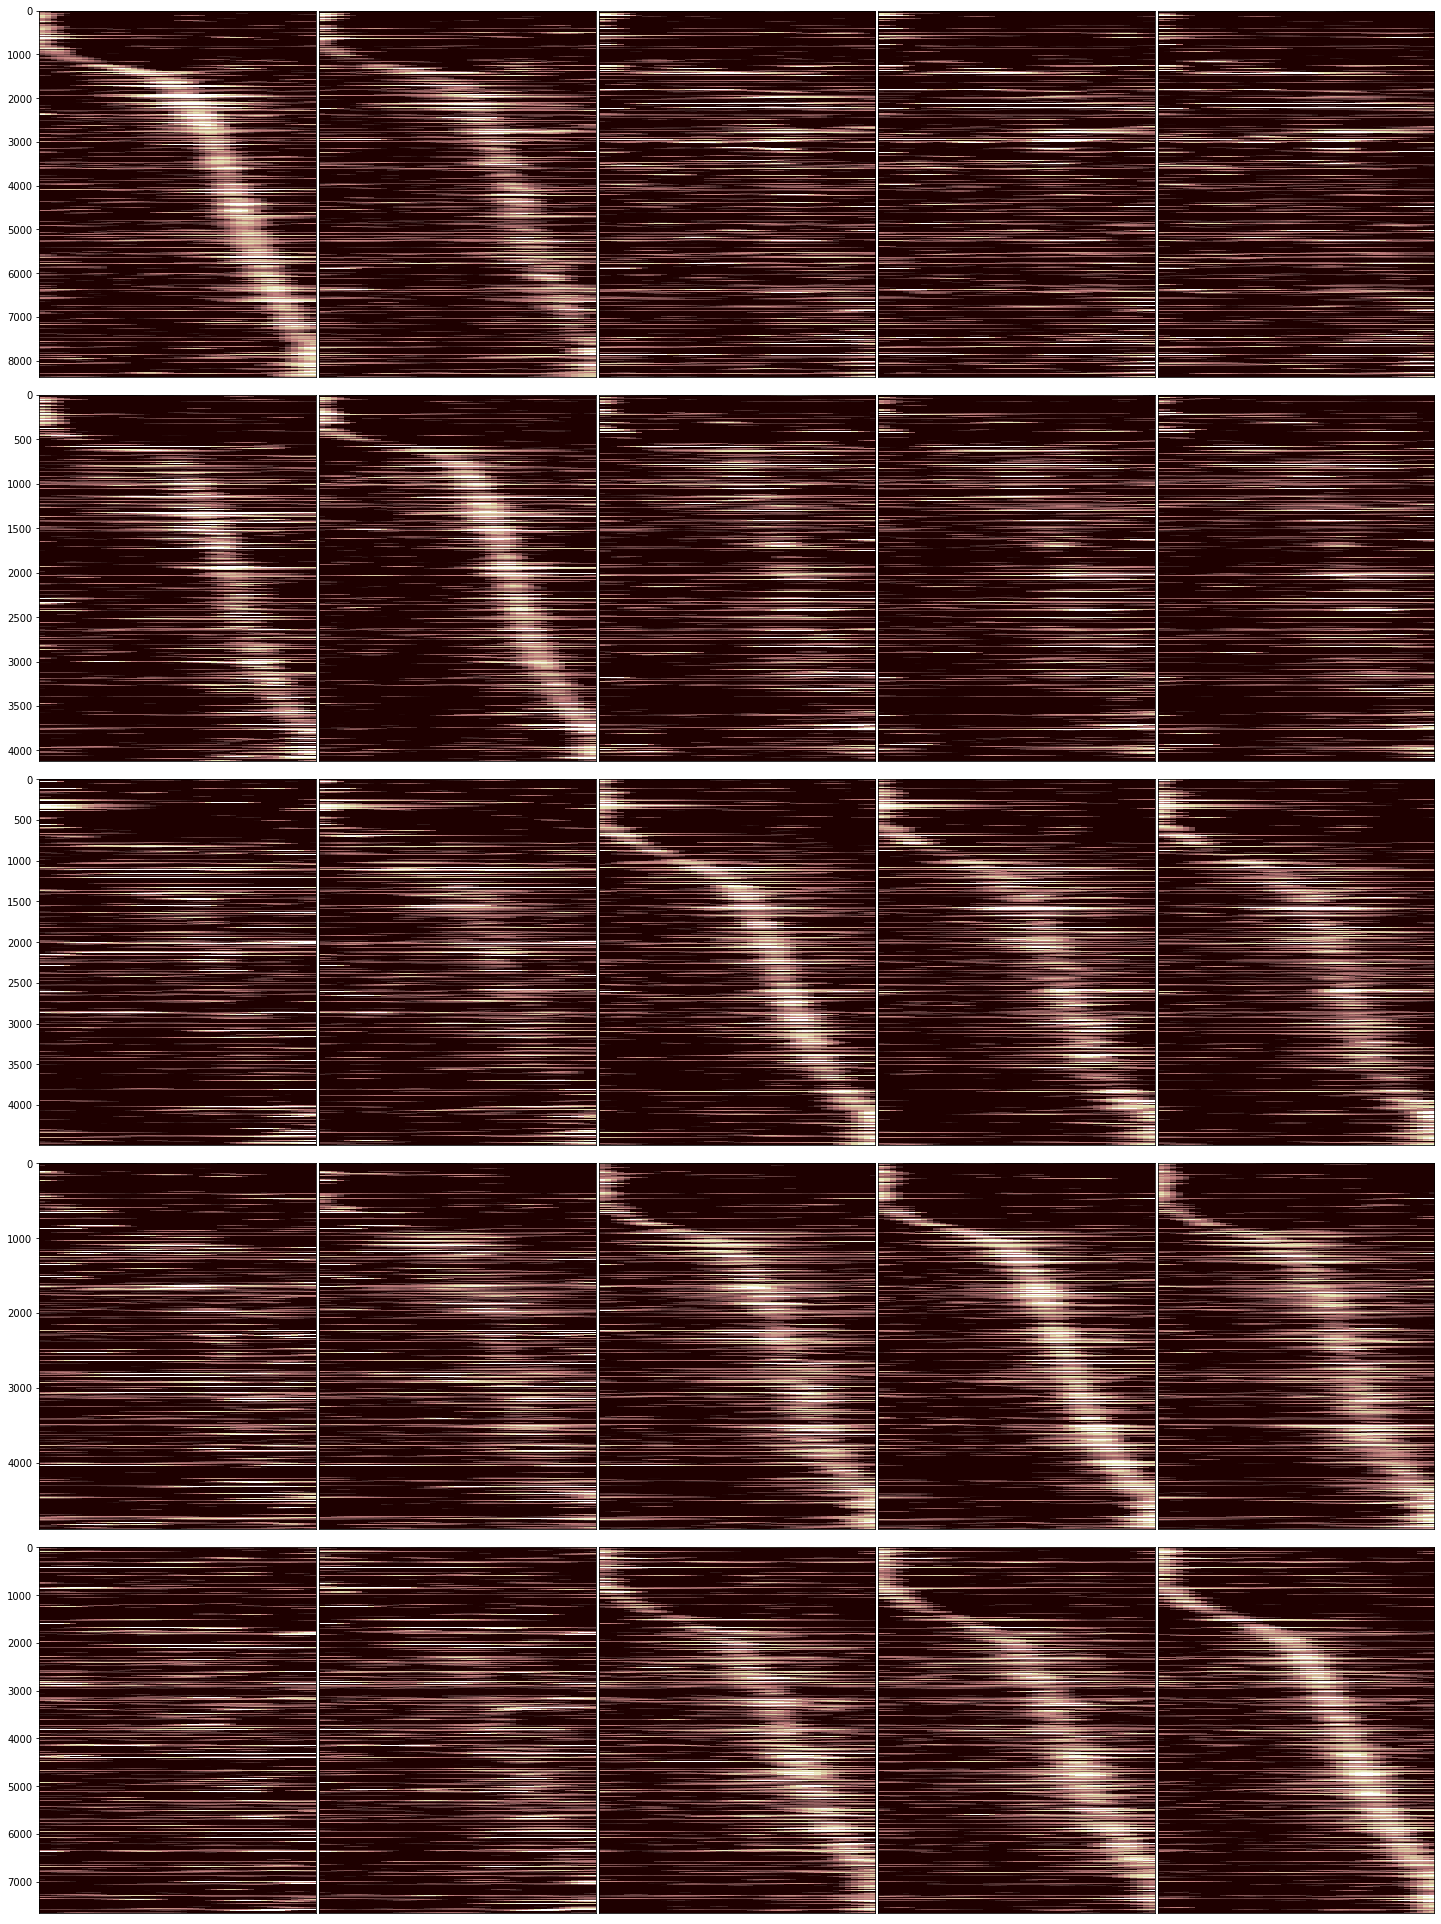

In [7]:
getSort = lambda fr : np.argsort(np.argmax(fr,axis=1))
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
for mouse in rare_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
#         masks = datadict[mouse][sess]['masks']
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
# f.savefig("D:\\Morph_Results\\figures\\rare_all_placecells.pdf",format="pdf")
# f.savefig("D:\\Morph_Results\\figures\\rare_all_placecells.png",format="png")

(3239, 45)
(3239, 45)
(3239, 45)
(3239, 45)
(3239, 45)
(2366, 45)
(2366, 45)
(2366, 45)
(2366, 45)
(2366, 45)
(2841, 45)
(2841, 45)
(2841, 45)
(2841, 45)
(2841, 45)
(2944, 45)
(2944, 45)
(2944, 45)
(2944, 45)
(2944, 45)
(2950, 45)
(2950, 45)
(2950, 45)
(2950, 45)
(2950, 45)


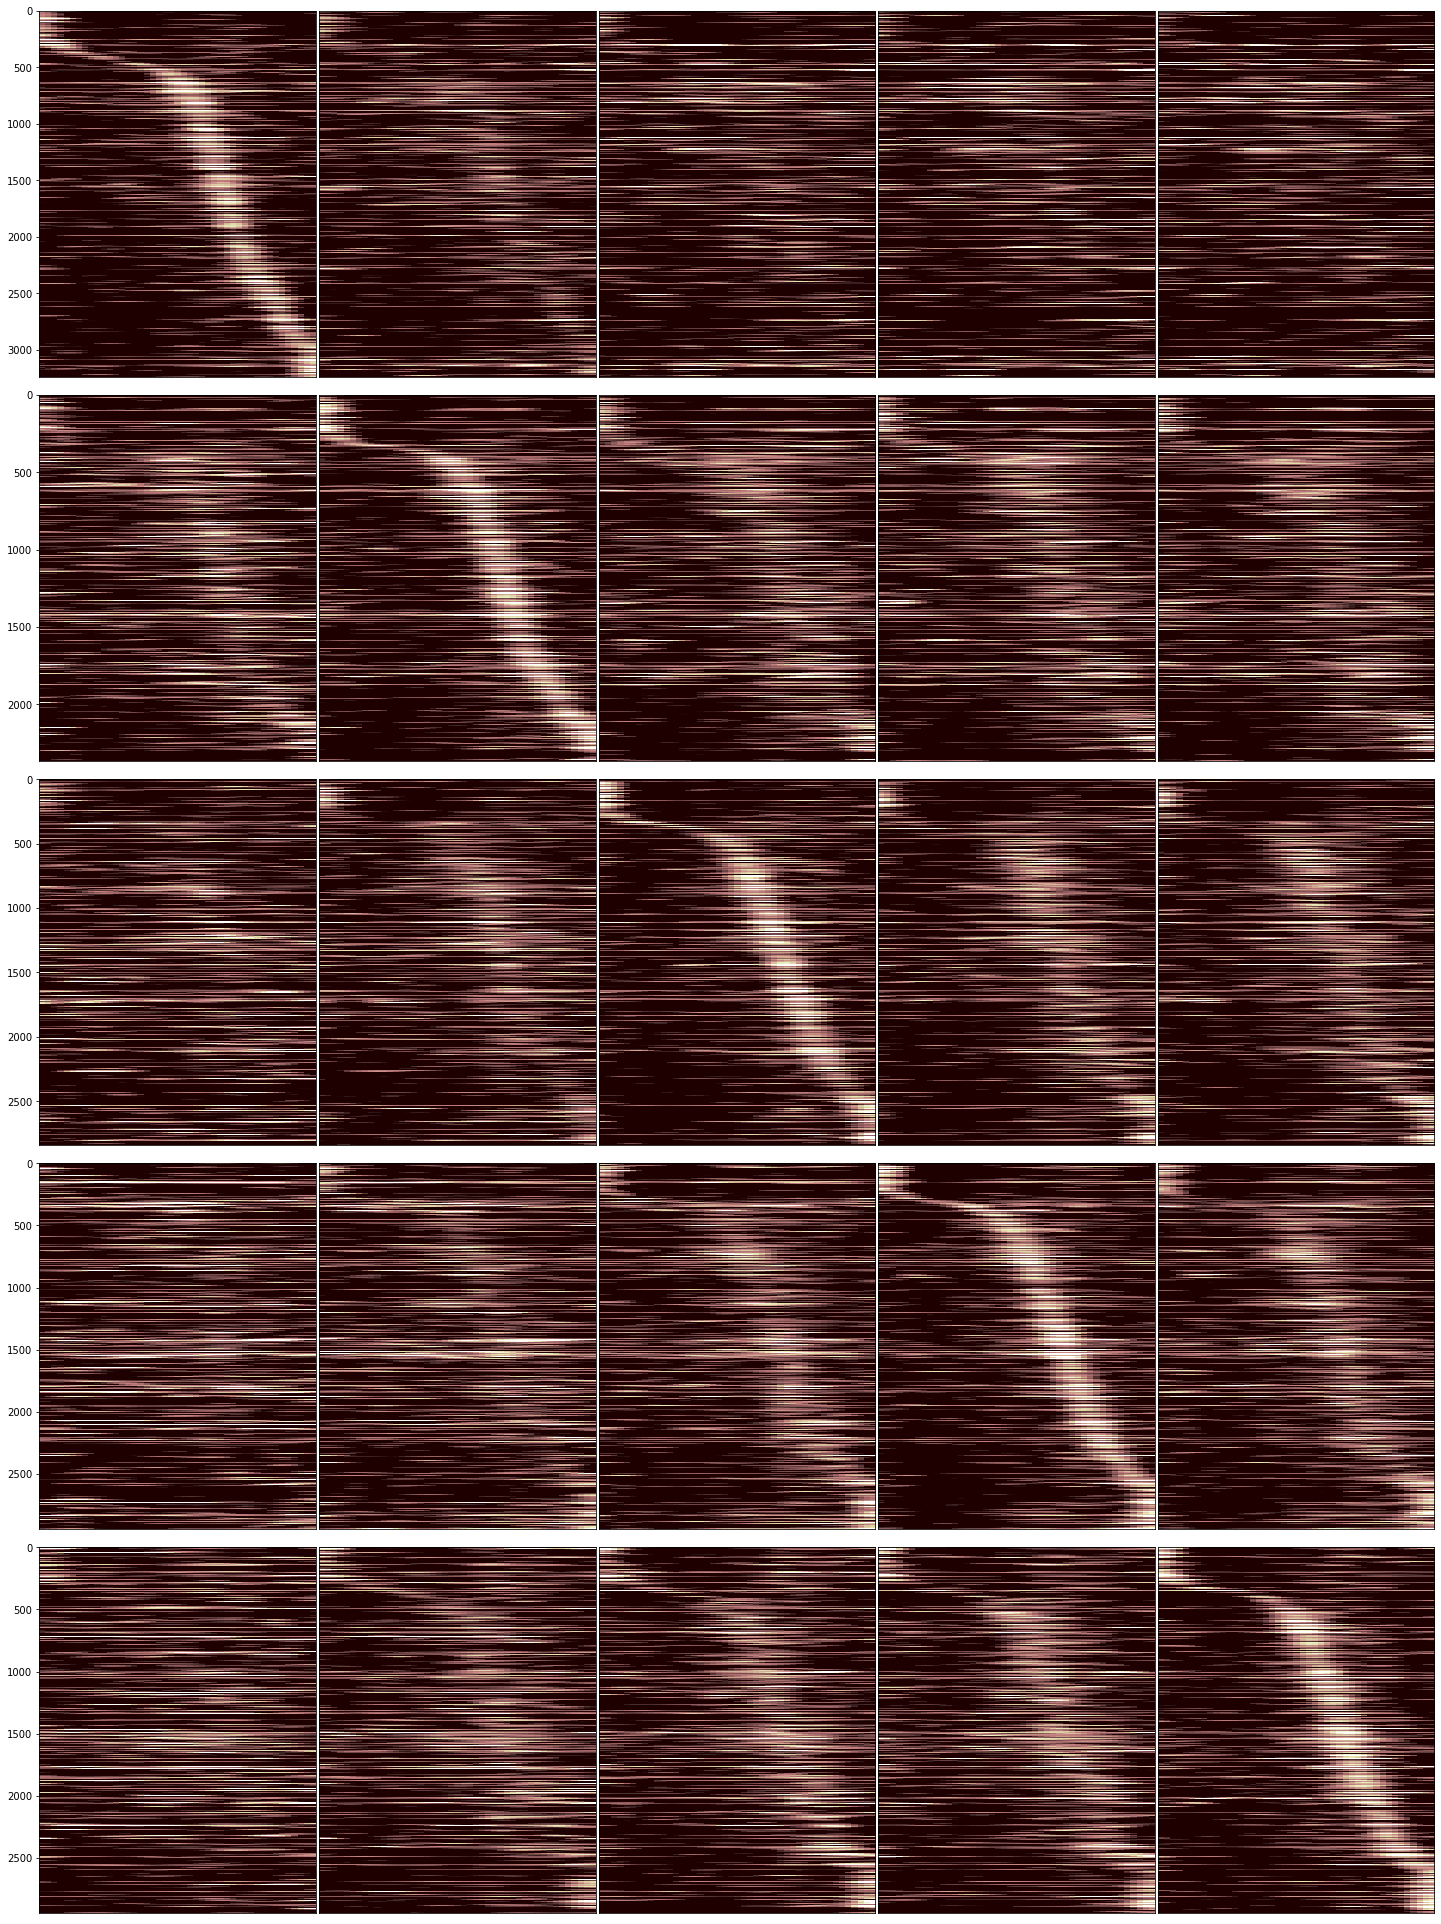

In [8]:
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
for mouse in freq_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
#         masks = datadict[mouse][sess]['masks']
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
# f.savefig("D:\\Morph_Results\\figures\\freq_all_placecells.pdf",format="pdf")
# f.savefig("D:\\Morph_Results\\figure/s\\frq_all_placecells.png",format="png")

In [59]:
mouselabel = []
rarefreqlabel = []
SM = []
SM_norm = []
sesslabel =[]
for mi, mouse in enumerate(mice):
    for si, (sess, sessdict) in enumerate(datadict[mouse].items()):
        # load data
        
        # OR mask
        for _i, (morph,mask) in enumerate(sessdict['masks'].items()):
            if _i == 0:
                ormask = mask
            else:
                ormask+=mask
        ormask = ormask>0
        
        # bin by morph value
        S_trial_mat = np.copy(sessdict['S_trial_mat'][:,:,ormask])
        S_binmat = np.zeros([5,*S_trial_mat.shape[1:]])
        for _i, m in enumerate(sessdict['masks'].keys()):
            S_binmat[_i,:,:] = S_trial_mat[sessdict['trial_info']['morphs']==m,:,:].mean(axis=0)
        S_binmat = S_binmat/np.linalg.norm(S_binmat,ord=2,axis=1,keepdims=True)
#         print(S_binmat.shape)
#         S_binmat = np.transpose(S_binmat, axes = (2,0,1))
        # similarity matrix 
        sm = np.matmul(np.transpose(S_binmat,axes=(2,0,1)),np.transpose(S_binmat,axes=(2,1,0)))
#         print(sm.shape)
        sm_norm = np.copy(sm)
        sm_norm[:,[0,1,2,3,4],[0,1,2,3,4]]=np.nan
        sm_norm = (sm_norm-np.nanmean(sm_norm))/np.nanstd(sm_norm)
#         sm[np.diag_indices_from(sm)]=np.nan
#         sm = (sm-sm[~np.isnan(sm)].mean())/np.std(sm[~np.isnan(sm)])
#         print(sm.shape)
        # save mouse and session index
        SM.append(sm)
        SM_norm.append(sm_norm)
        mouselabel.append(mi*np.ones((sm.shape[0],)))
        sesslabel.append(si*np.ones((sm.shape[0],)))
        if mi<5:
            rarefreqlabel.append(np.ones((sm.shape[0],)))
        else:
            rarefreqlabel.append(np.zeros((sm.shape[0],)))
    
SM = np.concatenate(SM,axis=0)
SM_norm = np.concatenate(SM_norm,axis=0)
mouselabel = np.concatenate(mouselabel)
rarefreqlabel = np.concatenate(rarefreqlabel)
sesslabel = np.concatenate(sesslabel)

In [85]:
# for each permutation of mouse labels
diff_perms = []
diff_perm_norm = []
iters =0
print(np.array(rare).sum())

for c, comb in enumerate(itertools.combinations(np.unique(mouselabel),6)):
    if c>0:
        rare_mask = np.zeros(mouselabel.shape)
        for _m_l  in comb:
#             print(_m_l)
            rare_mask += 1*(mouselabel==_m_l)
        rare_mask = rare_mask>0
#         print(SM.shape)
        diff_perms.append(SM[rare_mask,:,:].mean(axis=0)-SM[~rare_mask,:,:].mean(axis=0))
        diff_perm_norm.append(np.nanmean(SM_norm[rare_mask,:,:],axis=0)-np.nanmean(SM_norm[~rare_mask,:,:],axis=0))
print(c)
diff_perms = np.array(diff_perms)
print(diff_perms.shape)
diff_min,diff_max = np.percentile(diff_perms,2.5,axis=0),np.percentile(diff_perms,97.5,axis=0)
diff_perm_norm = np.array(diff_perm_norm)
# diff_min_norm,diff_max_norm = np.percentile(diff_perm_norm,.05,axis=0),np.percentile(diff_perm_norm,99.95,axis=0)
diff_min_norm,diff_max_norm = np.amin(diff_perm_norm,axis=0),np.amax(diff_perm_norm,axis=0)


5


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


923
(923, 5, 5)


In [86]:
1./924

0.0010822510822510823

[[ 0.          0.00460178 -0.08382711 -0.08513677 -0.06349417]
 [ 0.00460178  0.         -0.11294024 -0.11721879 -0.09492437]
 [-0.08382711 -0.11294024  0.         -0.03603443 -0.01042723]
 [-0.08513677 -0.11721879 -0.03603443  0.         -0.00885283]
 [-0.06349417 -0.09492437 -0.01042723 -0.00885283  0.        ]]
diff [[        nan  0.44126447 -0.08595379 -0.06976115  0.08398885]
 [ 0.44126447         nan -0.38849508 -0.39871866 -0.24109963]
 [-0.08595379 -0.38849508         nan  0.10359408  0.279824  ]
 [-0.06976115 -0.39871866  0.10359408         nan  0.27535691]
 [ 0.08398885 -0.24109963  0.279824    0.27535691         nan]]
min [[        nan -0.45598474 -0.3316578  -0.3991713  -0.28099762]
 [-0.45598474         nan -0.38591607 -0.39694804 -0.25961221]
 [-0.3316578  -0.38591607         nan -0.27693893 -0.4244851 ]
 [-0.3991713  -0.39694804 -0.27693893         nan -0.35091575]
 [-0.28099762 -0.25961221 -0.4244851  -0.35091575         nan]]
max [[       nan 0.43975406 0.3316578  0.39

C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


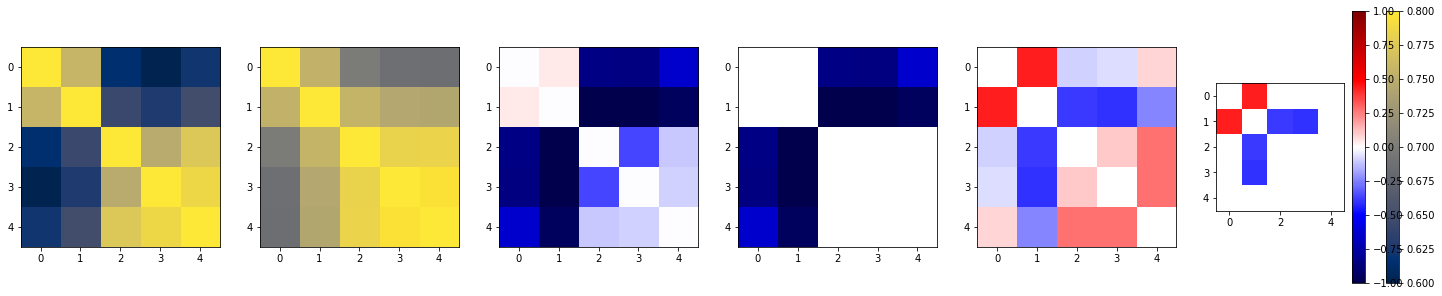

In [88]:
f,ax = plt.subplots(1,6,figsize= [25,5])
muf,mur = SM[rarefreqlabel==0,:,:].mean(axis=0),SM[rarefreqlabel==1,:,:].mean(axis=0)
diff = mur-muf
im=ax[0].imshow(mur,cmap='cividis',vmin=.6,vmax=.8)
f.colorbar(im)
ax[1].imshow(muf,cmap='cividis',vmin=.6,vmax=.8)
ax[2].imshow(diff,cmap='seismic',vmin=-.1,vmax=.1)
print(diff)
mask = ((diff>diff_max) + (diff<diff_min))>0
diff[~mask]=np.nan
ax[3].imshow(diff,cmap='seismic',vmin=-.1,vmax=.1)


muf,mur = np.nanmean(SM_norm[rarefreqlabel==0,:,:],axis=0),np.nanmean(SM_norm[rarefreqlabel==1,:,:],axis=0)
diff = mur-muf
print('diff',diff)
print('min',diff_min_norm)
print('max',diff_max_norm)
mask = ((diff<diff_min_norm) + (diff>diff_max_norm))>0
print(mask)
# diff[~mask]=np.nan
im=ax[4].imshow(diff,cmap='seismic',vmin=-1,vmax=1)

# t,p = sp.stats.ttest_ind(SM[rarefreqlabel==0,:],SM[rarefreqlabel==1,:],axis=0)
# mask = p<.005
# diff = muf-mur
diff[~mask]=np.nan
im = ax[5].imshow(diff,cmap='seismic',vmin=-1,vmax=1)
f.colorbar(im)
#
f.savefig("D:\\Morph_Results\\figures\\simmat_allplacecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\simmat_allplacecells.png",format="png")

In [16]:
print(SM.shape)

(24958, 5, 5)


In [16]:
print(SI[0]['all'].shape)

NameError: name 'SI' is not defined

In [4]:
# loop through mice

In [17]:
# numbers for main text

num = 0
den = 0
orcount = 0
andcount = 0 
count0,count1 = 0,0
for mouse in rare_mice: 
    print(mouse)
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
        allmask = masks[0]
        
        orcount += (masks[0]|masks[1]).sum()
        andcount += (masks[0]&masks[1]).sum()
        count0+= masks[0].sum()
        count1+=masks[1].sum()
        print(allmask.shape)
        for k,mask in masks.items():
            allmask = allmask|mask
        
        num += allmask.sum()
        den += allmask.shape[0]
print("Total number of place cells: %f" % num,"Pecent: %f" % (num/den))
print("0 pcnt %f" % (count0/den),"1 pcnt %f" % (count1/den),"random ovlp %f" % (count0/den*count1/den),"actual ovlp %f" %(andcount/den))
# print("0 pcnt %f" % (count0/num),"1 pcnt %f" % (count1/num),"random ovlp %f" % (count0/num*count1/num),"actual ovlp %f" %(andcount/num))

4139265.3
(1828,)
(1904,)
(1817,)
(1708,)
(1715,)
4139265.4
(1632,)
(1656,)
(1515,)
(1650,)
(1498,)
(1631,)
4139265.5
(915,)
(976,)
(984,)
(932,)
(1047,)
4222168.1
(919,)
(1035,)
(1074,)
(940,)
4343703.1
(1194,)
4343706
(71,)
(2336,)
(2652,)
(1403,)
(1617,)
Total number of place cells: 15847.000000 Pecent: 0.432399
0 pcnt 0.228246 1 pcnt 0.209092 random ovlp 0.047724 actual ovlp 0.060547


In [18]:
.2285*.2094

0.047847900000000006

In [19]:
# numbers for main text

num = 0
den = 0
orcount = 0
andcount = 0 
count0,count1 = 0,0
for mouse in freq_mice: 
    print(mouse)
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
        allmask = masks[0]
        
        orcount += (masks[0]|masks[1]).sum()
        andcount += (masks[0]&masks[1]).sum()
        count0+= masks[0].sum()
        count1+=masks[1].sum()
        print(allmask.shape)
        for k,mask in masks.items():
            allmask = allmask|mask
        
        num += allmask.sum()
        den += allmask.shape[0]
print("Total number of place cells: %f" % num,"Pecent: %f" % (num/den))
print("0 pcnt %f" % (count0/den),"1 pcnt %f" % (count1/den),"random ovlp %f" % (count0/den*count1/den),"actual ovlp %f" %(andcount/den))

4222153.1
(301,)
(273,)
(237,)
4222153.2
(2127,)
(2149,)
(2046,)
(2006,)
4222153.3
(161,)
4222174.1
(1963,)
(1998,)
(2047,)
(2117,)
(1901,)
4222154.1
(309,)
(571,)
(326,)
(311,)
(257,)
4343702.1
(3313,)
(2875,)
(2746,)
Total number of place cells: 8933.000000 Pecent: 0.297430
0 pcnt 0.107844 1 pcnt 0.098222 random ovlp 0.010593 actual ovlp 0.019778


[[], [], [], [], [], [], [], [], [], [], [], []]
4139265.3 [0.17231947483588622, 0.15336134453781514, 0.15244909190974132, 0.2189695550351288, 0.18483965014577258]
4139265.4 [0.2028186274509804, 0.2222222222222222, 0.21848184818481847, 0.17757575757575758, 0.18891855807743657, 0.17290006131207847]
4139265.5 [0.2262295081967213, 0.2489754098360656, 0.25914634146341464, 0.22532188841201717, 0.20630372492836677]
4222168.1 [0.3928182807399347, 0.28502415458937197, 0.3808193668528864, 0.4106382978723404]
4343703.1 [0.2638190954773869]
4343706 [0.09859154929577464, 0.2529965753424658, 0.21116138763197587, 0.2615823235923022, 0.29684601113172543]
4222153.1 [0.053156146179401995, 0.08424908424908426, 0.05063291139240506]
4222153.2 [0.09685002350728726, 0.12238250348999535, 0.14271749755620725, 0.13858424725822532]
4222153.3 [0.08695652173913043]
4222174.1 [0.13499745287824758, 0.15265265265265265, 0.2554958475818271, 0.09730751062824752, 0.1693845344555497]
4222154.1 [0.03559870550161812, 0.03

[Text(0, 0, 'R1'),
 Text(0, 0, 'R2'),
 Text(0, 0, 'R3'),
 Text(0, 0, 'R4'),
 Text(0, 0, 'R5'),
 Text(0, 0, 'R6'),
 Text(0, 0, 'F1'),
 Text(0, 0, 'F2'),
 Text(0, 0, 'F3'),
 Text(0, 0, 'F4'),
 Text(0, 0, 'F5'),
 Text(0, 0, 'F6')]

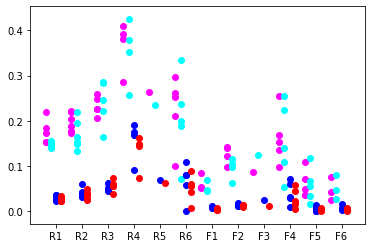

In [22]:
# numbers for main text

count0,count1 = [[]]*len(mice),[[]]*len(mice)
print(count0)
randovlp,actlovlp= [[]]*len(mice),[[]]*len(mice)
randovlp_all,actlovlp_all = [],[]
for m,mouse in enumerate(mice): 
#     
    count0[m],count1[m],randovlp[m],actlovlp[m]=[],[],[],[]
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        for k, p in pvals.items():
            masks[k] = pvals[k]<.05
        
        count0[m].append(masks[0].mean())
#         print(m,masks[0].mean())
        count1[m].append(masks[1].mean())
        randovlp[m].append(masks[0].mean()*masks[1].mean())
        actlovlp[m].append((masks[0]&masks[1]).mean())
        
        randovlp_all.append(masks[0].mean()*masks[1].mean())
        actlovlp_all.append((masks[0]&masks[1]).mean())
    print(mouse,count0[m])

print(count0[2])
f, ax = plt.subplots()
for m in range(len(mice)):
#     print(len(count0[m]))
#     jit = .3*(np.random.rand()-.5)
    ax.scatter(m*np.ones([len(count0[m]),])-.4,count0[m],color=plt.cm.cool(1.))
    ax.scatter(m*np.ones([len(count1[m]),])-.2,count1[m],color=plt.cm.cool(0.))
    ax.scatter(m*np.ones([len(count1[m]),])+0,actlovlp[m],color='blue')
    ax.scatter(m*np.ones([len(count1[m]),])+.2,randovlp[m],color='red')

ax.set_xticks(np.arange(len(mice)))
ax.set_xticklabels(['R1','R2','R3','R4','R5','R6','F1','F2','F3','F4','F5','F6'])
# f.savefig("D:\\Morph_Results\\figures\\pc_fracs.pdf",format="pdf")

47
160.0 1.909725445431717e-05
-4.867154257689973 1.3709071349721284e-05
-4.867154257689973 1.3709071349721284e-05


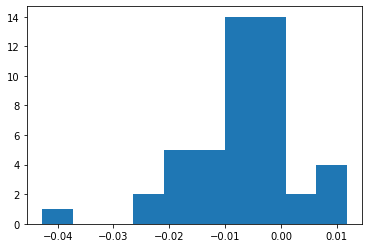

In [33]:
f,ax = plt.subplots()
print(len(randovlp_all))
ax.hist(np.array(randovlp_all)-np.array(actlovlp_all))
# print(np.array(randovlp_all).mean())
stat,p = sp.stats.wilcoxon(np.array(randovlp_all)-np.array(actlovlp_all))
print(stat,p)
t,p = sp.stats.ttest_rel(np.array(randovlp_all),np.array(actlovlp_all))
print(t,p)
t,p = sp.stats.ttest_1samp(np.array(randovlp_all)-np.array(actlovlp_all),0)
print(t,p)

(45, 2219)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)
(2219, 45)


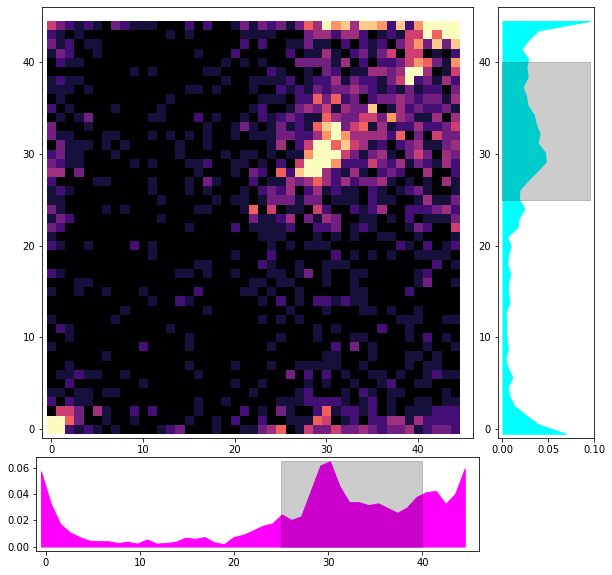

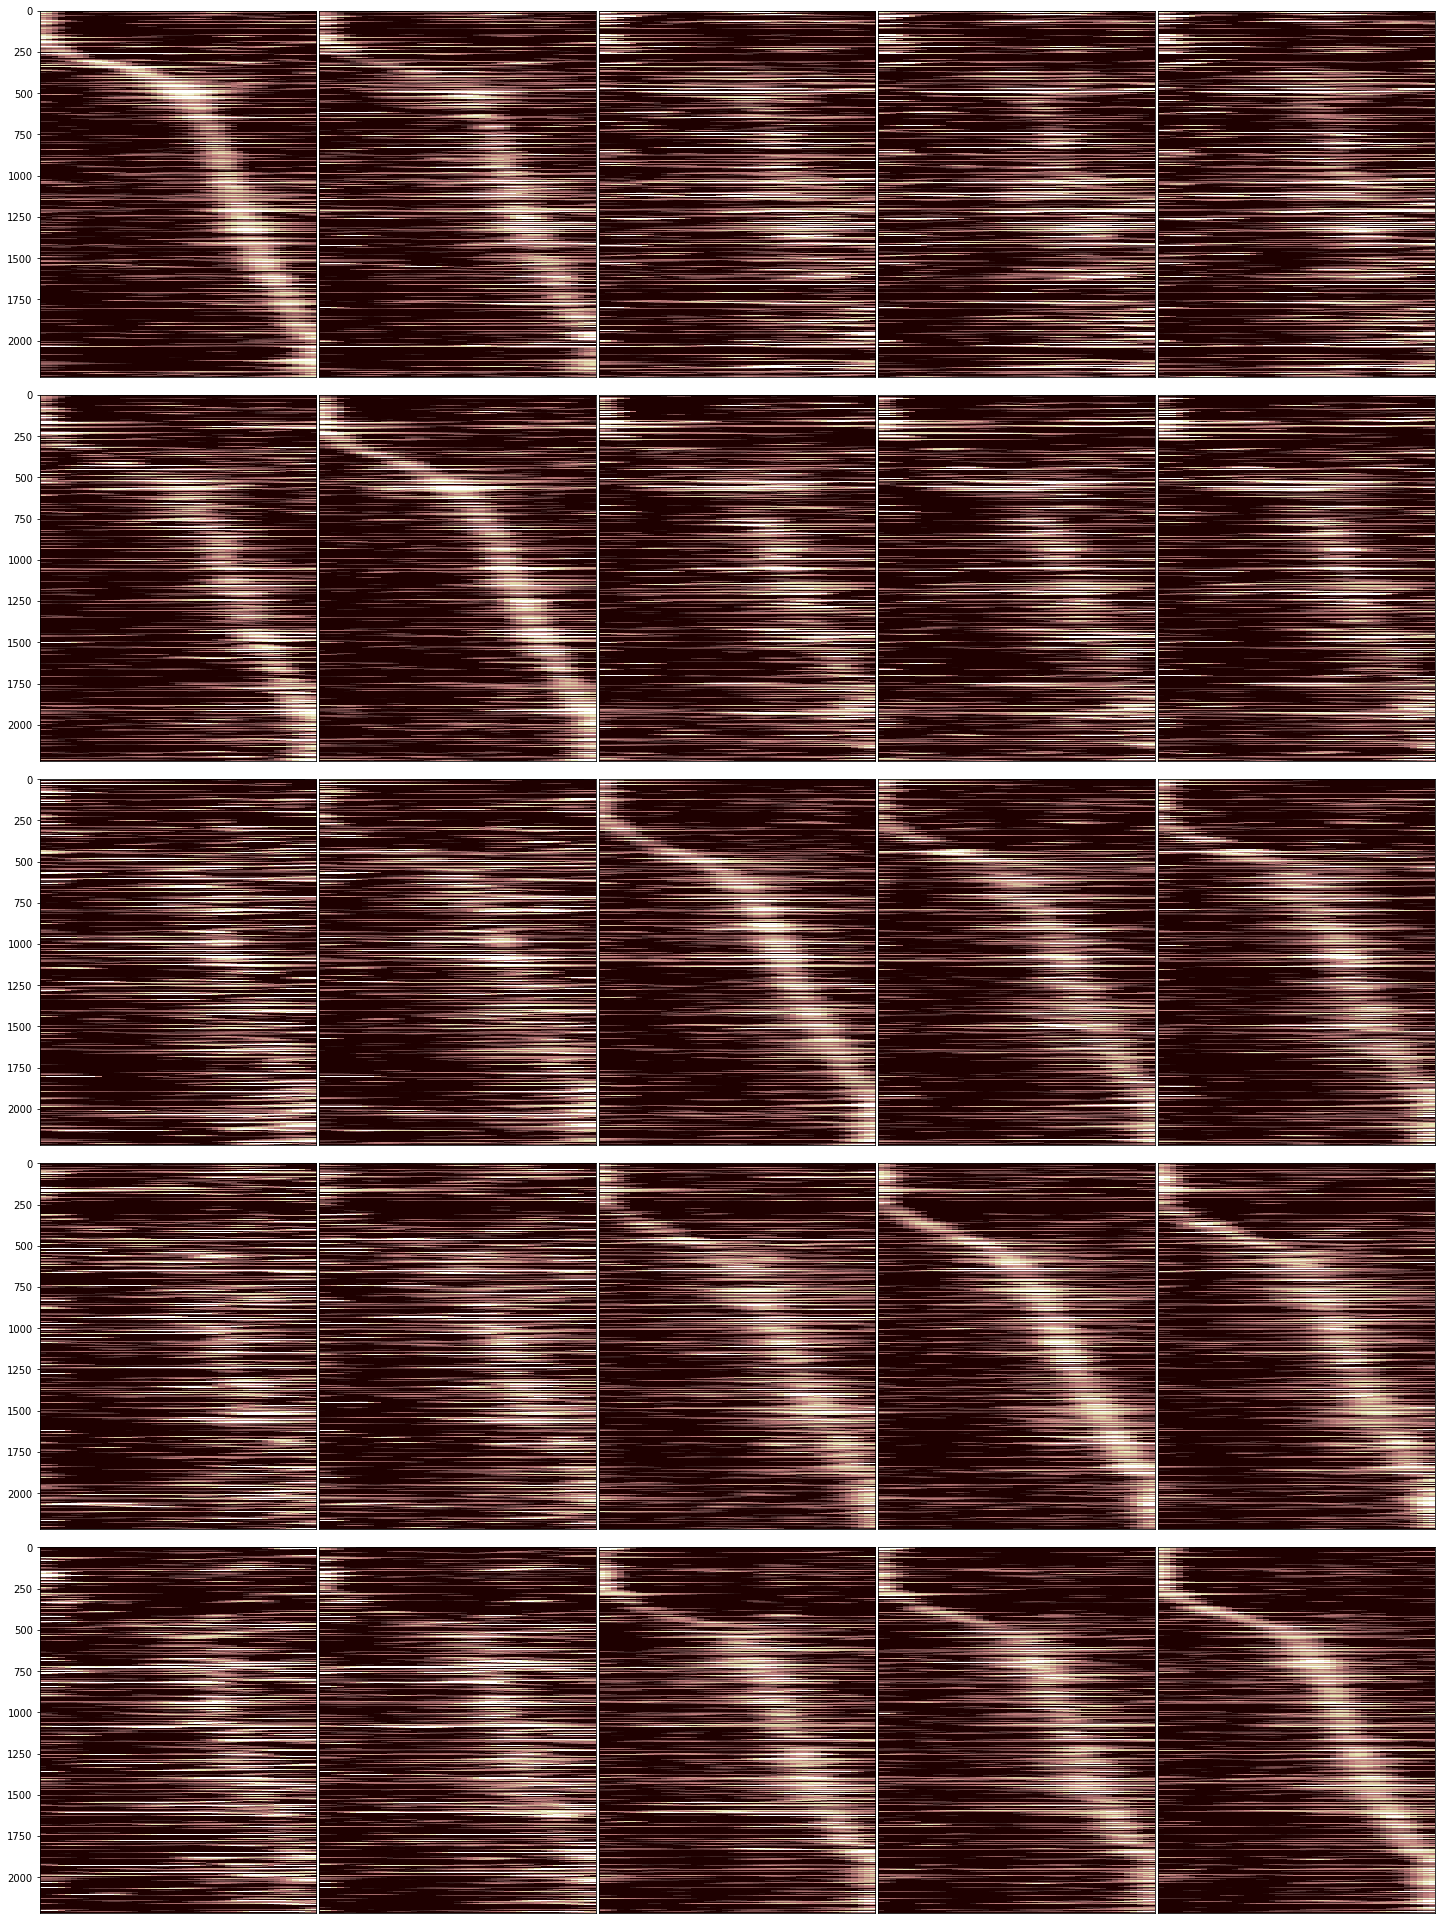

In [85]:
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
comm0,comm1 = [],[]
for mouse in rare_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        mask = (pvals[0]<.05) & (pvals[1]<.05)
        for k, p in pvals.items():
            masks[k]=mask
        
        
        pcs = datadict[mouse][sess]['S_trial_mat'][:,:,mask]
        comm0.append(np.nanmean(pcs[datadict[mouse][sess]['trial_info']['morphs']==0,:,:],axis=0))
        comm1.append(np.nanmean(pcs[datadict[mouse][sess]['trial_info']['morphs']==1,:,:],axis=0))
        
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
comm0 = np.concatenate(comm0,axis=-1)
comm1 = np.concatenate(comm1,axis=-1)
print(comm0.shape)
       

f,ax = pc.common_cell_remap_heatmap(comm0,comm1,norm=False)
f.savefig("D:\\Morph_Results\\figures\\rare_common_pc_heatmap.pdf",format="pdf")
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
f.savefig("D:\\Morph_Results\\figures\\rare_common_pc.pdf",format="pdf")

(45, 594)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)
(594, 45)


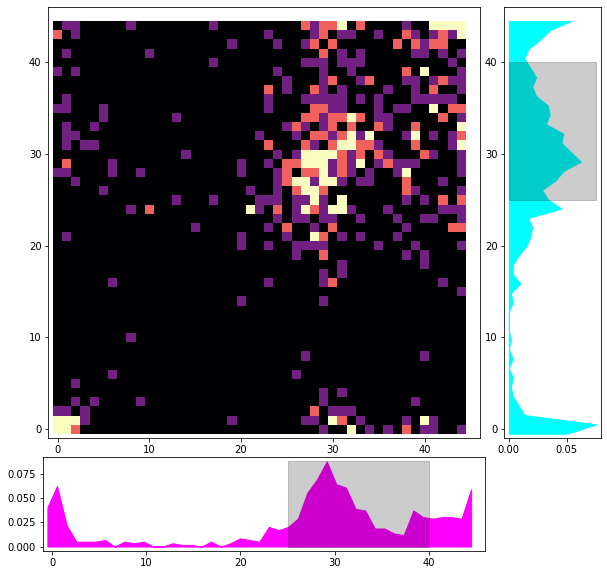

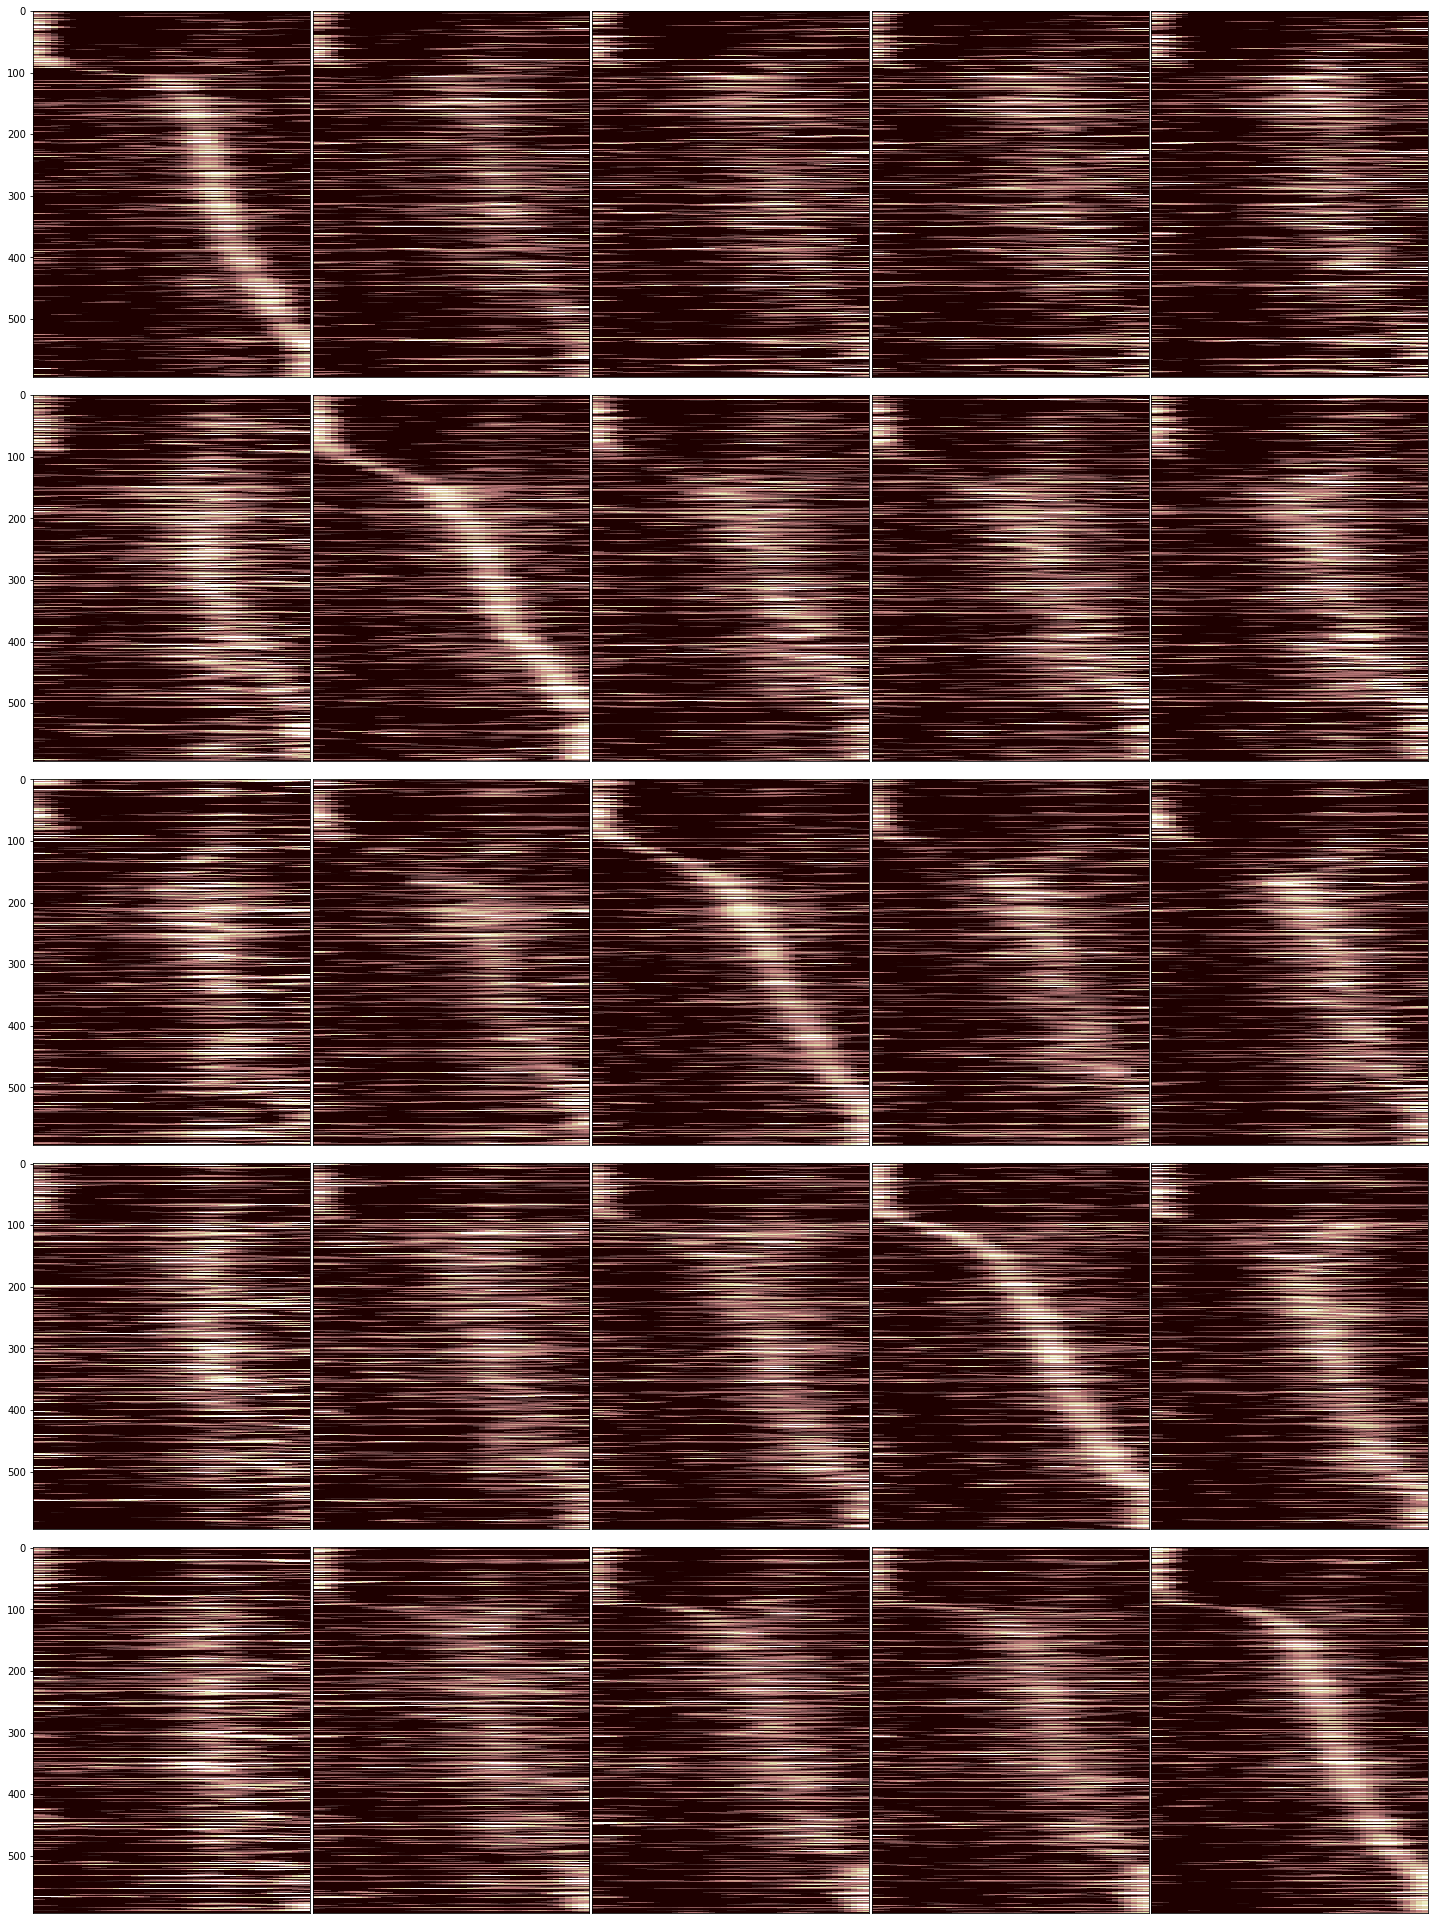

In [86]:
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
comm0,comm1 = [],[]
for mouse in freq_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        pvals = datadict[mouse][sess]['pvals']
        masks={}
        mask = (pvals[0]<.05) & (pvals[1]<.05)
        for k, p in pvals.items():
            masks[k]=mask
        
        
        pcs = datadict[mouse][sess]['S_trial_mat'][:,:,mask]
        comm0.append(np.nanmean(pcs[datadict[mouse][sess]['trial_info']['morphs']==0,:,:],axis=0))
        comm1.append(np.nanmean(pcs[datadict[mouse][sess]['trial_info']['morphs']==1,:,:],axis=0))
        
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
comm0 = np.concatenate(comm0,axis=-1)
comm1 = np.concatenate(comm1,axis=-1)
print(comm0.shape)
       

f,ax = pc.common_cell_remap_heatmap(comm0,comm1,norm=False)
f.savefig("D:\\Morph_Results\\figures\\freq_common_pc_heatmap.pdf",format="pdf")
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
f.savefig("D:\\Morph_Results\\figures\\freq_common_pc.pdf",format="pdf")